# Figure 1. Sharpness of spike initiation with distal initiation (Na channels clustered at a single point). 

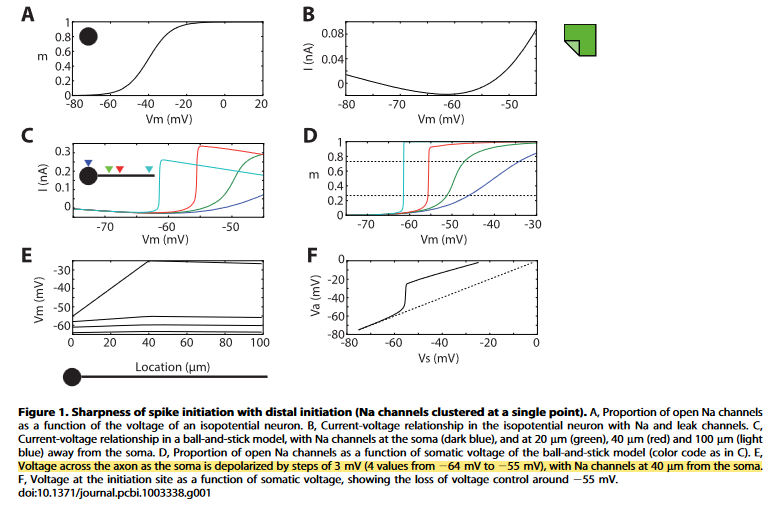

WARNING    Variable vc is a shared variable but it will be recorded once for every target. [brian2.monitors.statemonitor]
WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
INFO       No numerical integration method specified for group 'spatialneuron', using method 'exact' (took 0.08s). [brian2.stateupdaters.base.method_choice]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 6s


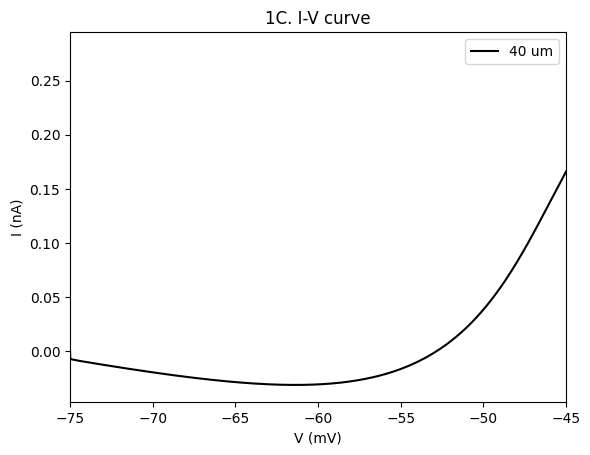

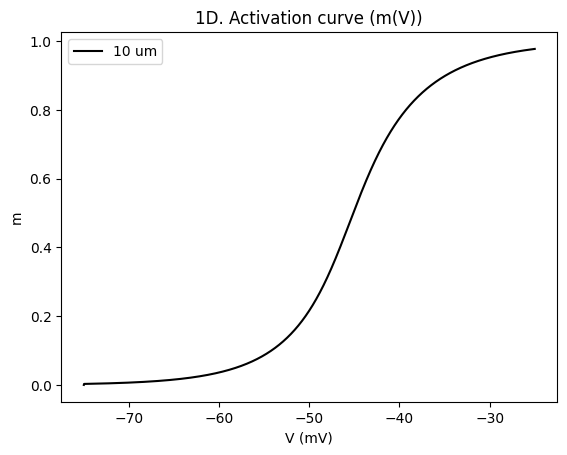

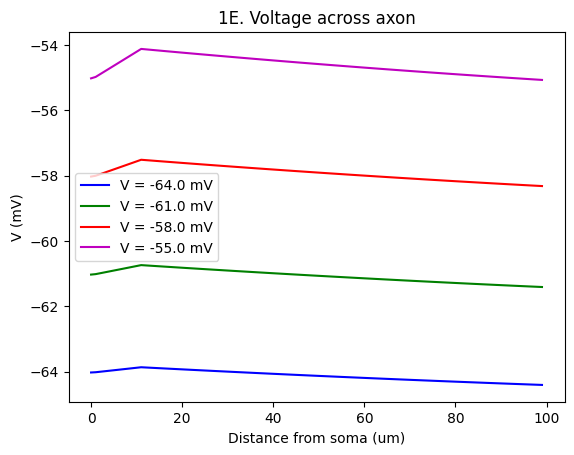

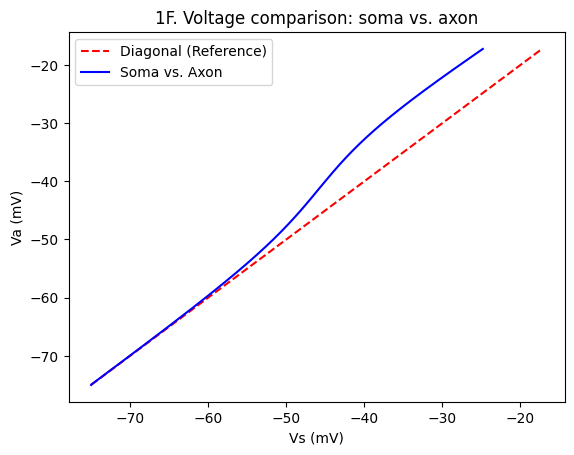

In [1]:
from brian2 import *
import numpy as np

# Defining passive parameters
EL = -75*mV  # Resting membrane potential
S = 7.85e-9 * meter**2  # Membrane surface area (sphere of 50 μm diameter)
Cm = 0.75 * uF / cm**2  # Specific membrane capacitance
gL = 1. / (30000 * ohm * cm**2)  # Leak conductance per unit area
Ri = 150 * ohm * cm  # Axial resistance

# Na+ channel parameters

ENa = 60*mV  # Sodium reversal potential
ka = 6*mV  # Activation slope
va = -40*mV  # Activation half-voltage
gNa_0 = gL * 2 * S  # Sodium conductance
taum = 0.1*ms  # Na+ activation time constant

defaultclock.dt = 0.025*ms

# neuron morphology
morpho = Soma(50*um)  
morpho.axon = Cylinder(diameter=1*um, length=300*um, n=300)  # n = 300 compartments

location = 10*um # channel placement
duration = 500*ms


eqs = '''
Im = gL*(EL - v) + gclamp*(vc - v) + gNa*m*(ENa - v) : amp/meter**2
dm/dt = (minf - m) / taum : 1  # Simplified Na+ channel activation
minf = 1 / (1 + exp((va - v) / ka)) : 1
gclamp : siemens/meter**2
gNa : siemens/meter**2
vc = EL + 50*mV * t/duration : volt (shared)  # Voltage clamp with a ramping voltage command

'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=Cm, Ri=Ri)

compartment = morpho.axon[location]

neuron.v = EL  
neuron.gclamp[0] = gL * 500  # apply a strong voltage clamp at the soma
neuron.gNa[compartment] = gNa_0 / neuron.area[compartment]  # set Na+ conductance

mon = StateMonitor(neuron, ['v', 'vc', 'm'], record=True)

run(duration, report='text')


# 1c. I-V curve

plt.figure()

plot(
    mon[0].vc/mV, 
    -((mon[0].vc - mon[0].v)*(neuron.gclamp[0]))*neuron.area[0]/nA, 'k',
    label='40 um'
)

xlabel('V (mV)')
ylabel('I (nA)')
xlim(-75, -45)
title('1C. I-V curve')
legend()


# 1d. activation curve (m(V))

plt.figure()

plot(mon[0].vc/mV, mon[compartment].m, 'k',
     label='10 um')

xlabel('V (mV)')
ylabel('m')
title('1D. Activation curve (m(V))')
legend()


# 1e. voltage across the axon

plt.figure()

dt_per_volt = len(mon.t) / (50*mV) 
colors = ['b', 'g', 'r', 'm']  
voltages = [-64*mV, -61*mV, -58*mV, -55*mV] 

for i, v in enumerate(voltages):
    plot(mon.v[:100, int(dt_per_volt * (v - EL))]/mV, colors[i], label=f'V = {v/mV} mV')

xlabel('Distance from soma (um)')
ylabel('V (mV)')
title('1E. Voltage across axon')
legend(loc='best')


# 1f. voltage comparison: soma vs. axon

plt.figure()

plot(mon[compartment].v/mV, mon[compartment].v/mV, 'r--', label='Diagonal (Reference)')
plot(mon[0].v/mV, mon[compartment].v/mV, 'b', label='Soma vs. Axon')

xlabel('Vs (mV)')
ylabel('Va (mV)')
title('1F. Voltage comparison: soma vs. axon')
legend()

# LIF vs HH


--> verklaar verschil in schaal 

INFO       No numerical integration method specified for group 'spatialneuron_1', using method 'exact' (took 0.12s). [brian2.stateupdaters.base.method_choice]
WARNING    'v' is an internal variable of group 'spatialneuron_1', but also exists in the run namespace with the value -55. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 1. s
0.807425 s (80%) simulated in 10s, estimated 2s remaining.
1. s (100%) simulated in 12s
Max Voltage (Compartmental Model): -30.06 mV


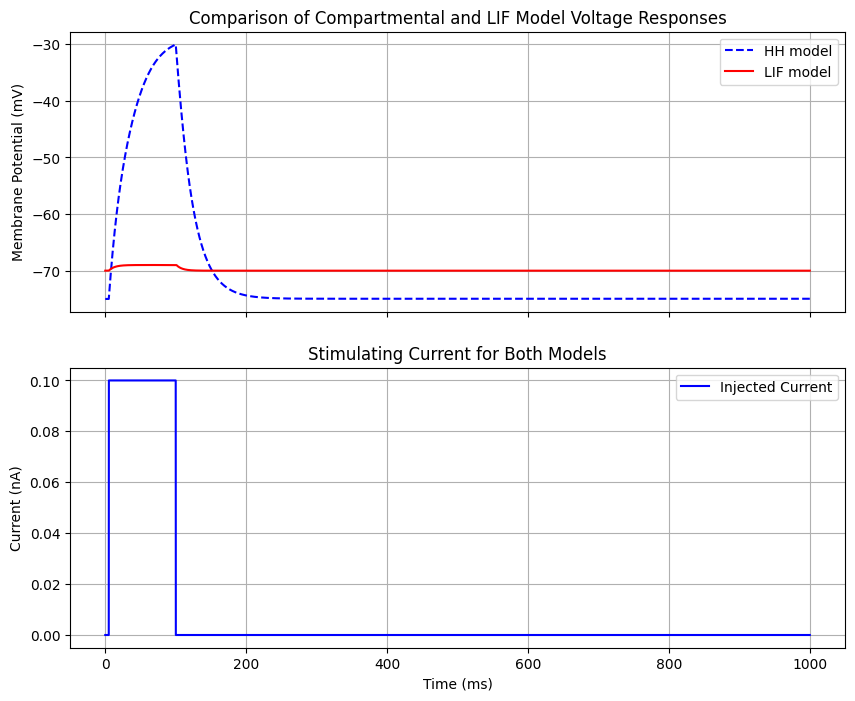

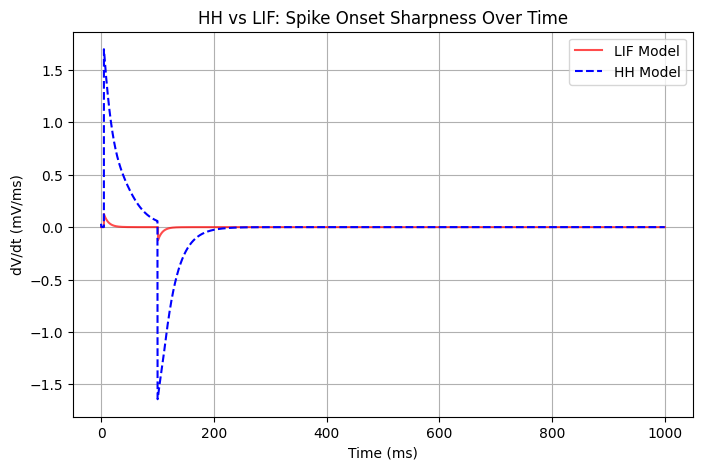

Number of spikes (LIF Model): 0


In [2]:
import numpy as np
import brian2 as b2
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory
from neurodynex3.tools import plot_tools
import matplotlib.pyplot as plt

b2.defaultclock.dt = 0.025 * b2.ms 

EL = -75 * b2.mV  
S = 7.85e-9 * b2.meter**2  
Cm = 0.75 * b2.uF / b2.cm**2  
gL = 1. / (30000 * b2.ohm * b2.cm**2)  
Ri = 150 * b2.ohm * b2.cm  

ENa = 60 * b2.mV 
ka = 6 * b2.mV  
va = -40 * b2.mV  

gNa_0 = gL * 0.1 * S  

I_min = 0.1 * b2.nA 

morpho = b2.Soma(50 * b2.um)
morpho.axon = b2.Cylinder(diameter=1 * b2.um, length=300 * b2.um, n=300)

location = 40 * b2.um  
duration = 1000 * b2.ms  

t_start = 5 * b2.ms
t_end = 100 * b2.ms
dt = b2.defaultclock.dt

simulation_time = duration
time_array = np.arange(0, simulation_time / b2.ms, dt / b2.ms) * b2.ms


current_density = np.where(
    (time_array >= t_start) & (time_array <= t_end), I_min / S, 0
) * (b2.amp / b2.meter**2)

I_injected = b2.TimedArray(current_density, dt=dt)

current_total = np.where(
    (time_array >= t_start) & (time_array <= t_end),
    I_min, 
    0
) * b2.amp 


eqs = '''
Im = gL*(EL - v) + gNa*m*(ENa - v) + I_injected(t) : amp/meter**2
dm/dt = (minf - m) / (0.1 * ms) : 1  # Na activation time constant
minf = 1 / (1 + exp((va - v) / ka)) : 1
gclamp : siemens/meter**2
gNa : siemens/meter**2
vc = EL + 50*mV * t/duration : volt (shared)
'''

neuron = b2.SpatialNeuron(morphology=morpho, model=eqs, Cm=Cm, Ri=Ri)

compartment = morpho.axon[location]

neuron.v = EL  

neuron.gclamp[0] = gL * 10  

neuron.gNa[compartment] = gNa_0 / neuron.area[compartment]

mon = b2.StateMonitor(neuron, ['v', 'vc', 'm'], record=True)

net = b2.Network(neuron, mon)
net.run(duration, report='text')

max_voltage = np.max(mon[compartment].v) / b2.mV
print(f"Max Voltage (Compartmental Model): {max_voltage:.2f} mV")

#plt.figure(figsize=(10, 6))
#plt.plot(mon.t / b2.ms, mon[compartment].v / b2.mV, 'k', label='SpatialNeuron Voltage (40 um)')

step_current = input_factory.get_step_current(t_start=5, t_end=100, unit_time=b2.ms, amplitude=I_min)
state_monitor, spike_monitor = LIF.simulate_LIF_neuron(input_current=step_current, simulation_time=1000 * b2.ms)

#plt.plot(state_monitor.t / b2.ms, state_monitor.v[0] / b2.mV, 'r', label='LIF Voltage Trace')

'''
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Comparison of SpatialNeuron and LIF Model Voltage Traces')
plt.legend()
plt.grid()
plt.show()
'''

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(mon.t / b2.ms, mon[compartment].v / b2.mV, 'b--', label='HH model')
axs[0].plot(state_monitor.t / b2.ms, state_monitor.v[0] / b2.mV, 'r', label='LIF model')
axs[0].set_ylabel('Membrane Potential (mV)')
axs[0].set_title('Comparison of Compartmental and LIF Model Voltage Responses')
axs[0].legend()
axs[0].grid()

axs[1].plot(time_array / b2.ms, current_total / b2.nA, 'b', label='Injected Current')
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Current (nA)')
axs[1].set_title('Stimulating Current for Both Models')
axs[1].legend()
axs[1].grid()

dv_dt = np.gradient(mon[compartment].v / b2.mV, mon.t / b2.ms)

'''

# plot dV/dt for HH model

plt.figure(figsize=(8, 4))
plt.plot(mon.t / b2.ms, dv_dt, 'r', label='dV/dt (Spike Onset Sharpness)')
plt.xlabel("Time (ms)")
plt.ylabel("dV/dt (mV/ms)")
plt.title("HH: Spike Onset Sharpness over time")
plt.legend()
plt.grid()
plt.show()

'''

# LIF spike sharpness

dv_dt_LIF = np.gradient(state_monitor.v[0] / b2.mV, state_monitor.t / b2.ms)

spike_times = spike_monitor.t / b2.ms  

sharpness_LIF = []
sharpness_time = []  

for spike_time in spike_times:
    idx = np.where(state_monitor.t / b2.ms >= spike_time - 1)[0][0] 
    max_dv_dt = np.max(dv_dt_LIF[idx:idx+10]) 
    sharpness_LIF.append(max_dv_dt)
    sharpness_time.append(spike_time)  

'''
# plot dV/dt over time for LIF
plt.figure(figsize=(8, 5))

plt.plot(state_monitor.t / b2.ms, dv_dt_LIF, 'r', alpha=0.7, label="dV/dt (Spike Onset Sharpness)")


plt.xlabel("Time (ms)")  
plt.ylabel("dV/dt (mV/ms)")  
plt.title("LIF: Spike Onset Sharpness Over Time")  
plt.legend()
plt.grid()
plt.show()

'''	

# plot dV/dt over time for both
plt.figure(figsize=(8, 5))

plt.plot(state_monitor.t / b2.ms, dv_dt_LIF, 'r', alpha=0.7, label="LIF Model")
plt.plot(mon.t / b2.ms, dv_dt, 'b--', label='HH Model')

plt.xlabel("Time (ms)")  
plt.ylabel("dV/dt (mV/ms)")  
plt.title("HH vs LIF: Spike Onset Sharpness Over Time")  
plt.legend()
plt.grid()
plt.show()

print("Number of spikes (LIF Model):", spike_monitor.count[0])


# Figure 3

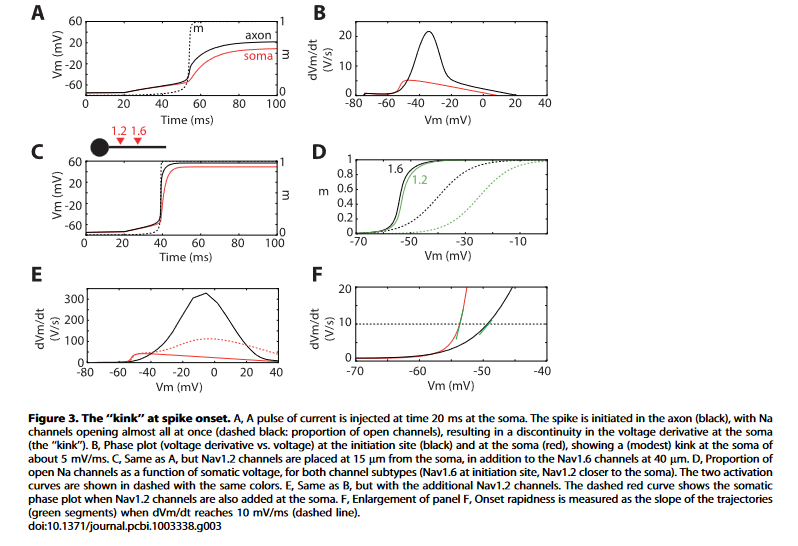

WARNING    'v' is an internal variable of group 'spatialneuron', but also exists in the run namespace with the value -55. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 20. ms
20. ms (100%) simulated in < 1s
Starting simulation at t=20. ms for a duration of 80. ms
80. ms (100%) simulated in < 1s


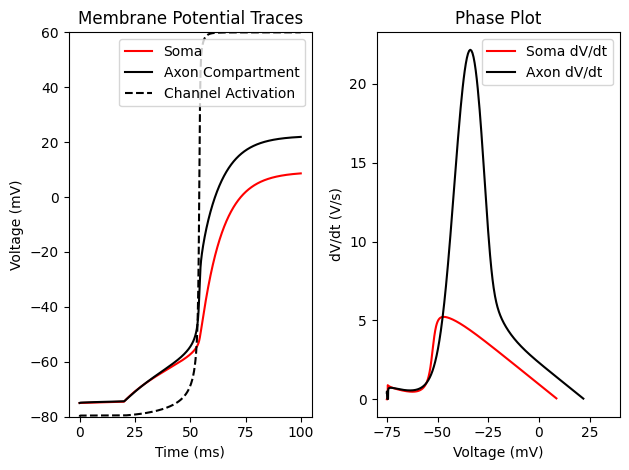

In [3]:
from brian2 import *

rest_potential = -75*mV
surface_area = 7.85e-9*meter**2 
capacitance = 0.75*uF/cm**2
leak_conductance = 1. / (30000*ohm*cm**2)
axial_resistance = 150*ohm*cm

sodium_reversal = 60*mV
activation_slope = 6*mV
activation_half = -40*mV
base_gNa = leak_conductance * 2 * surface_area
tau_m = 0.1*ms

codegen.target = 'numpy'
defaultclock.dt = 0.025*ms

neuron_structure = Soma(50*um)  
neuron_structure.axon = Cylinder(diameter=1*um, length=300*um, n=300)

sodium_location = 40*um  

equations = '''
Im = leak_conductance * (rest_potential - v) + gNa * activation * (sodium_reversal - v) : amp/meter**2
dactivation/dt = (steady_activation - activation) / tau_m : 1
steady_activation = 1 / (1 + exp((activation_half - v) / activation_slope)) : 1
gNa : siemens/meter**2
stim_current : amp (point current)
'''

axon_neuron = SpatialNeuron(morphology=neuron_structure, model=equations, 
                            Cm=capacitance, Ri=axial_resistance, 
                            method="exponential_euler")

target_compartment = neuron_structure.axon[sodium_location]
axon_neuron.v = rest_potential
axon_neuron.gNa[target_compartment] = base_gNa / axon_neuron.area[target_compartment]


data_logger = StateMonitor(axon_neuron, ['v', 'activation'], record=True)

simulation = Network(axon_neuron, data_logger)
simulation.run(20*ms, report='text')
axon_neuron.stim_current[0] = leak_conductance * 20*mV * axon_neuron.area[0]
simulation.run(80*ms, report='text')

subplot(121)
plot(data_logger.t/ms, data_logger[0].v/mV, 'r', label="Soma")
plot(data_logger.t/ms, data_logger[target_compartment].v/mV, 'k', label="Axon Compartment")
plot(data_logger.t/ms, data_logger[target_compartment].activation * (80+60) - 80, 'k--', label="Channel Activation")
ylim(-80, 60)
xlabel('Time (ms)')
ylabel('Voltage (mV)')
title('Membrane Potential Traces')
legend()

subplot(122)
dv_soma = diff(data_logger[0].v) / defaultclock.dt
dv_axon = diff(data_logger[target_compartment].v) / defaultclock.dt
plot((data_logger[0].v/mV)[1:], dv_soma/(volt/second), 'r', label="Soma dV/dt")
plot((data_logger[target_compartment].v/mV)[1:], dv_axon/(volt/second), 'k', label="Axon dV/dt")
xlim(-80, 40)
xlabel('Voltage (mV)')
ylabel('dV/dt (V/s)')
title('Phase Plot')
legend()
tight_layout()
show()


# Figure 4

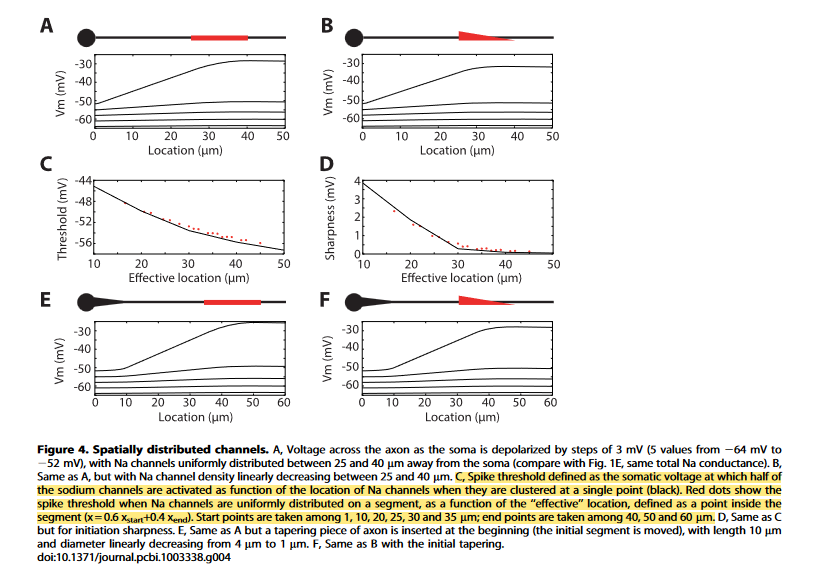

WARNING    'v' is an internal variable of group 'spatialneuron_2', but also exists in the run namespace with the value -55. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s


Text(0.5, 1.0, 'Voltage across axon')

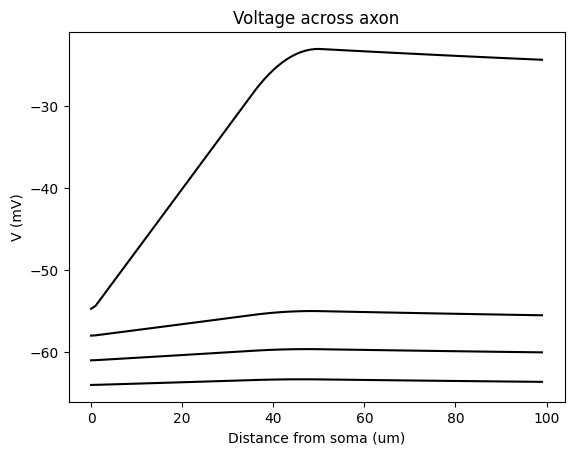

In [4]:
#4B 
from brian2 import *

start_scope()

EL = -75*mV  
S = 7.85e-9 * meter**2  
Cm = 0.75 * uF / cm**2  
gL = 1. / (30000 * ohm * cm**2) 
Ri = 150 * ohm * cm 

ENa = 60*mV 
ka = 6*mV  
va = -40*mV  
gNa_0 = gL * 2 * S  
taum = 0.1*ms  

defaultclock.dt = 0.025*ms

morpho = Soma(50*um)  
morpho.axon = Cylinder(diameter=1*um, length=300*um, n=300) 

Na_start = (25 + 10)*um
Na_end = (40 + 10)*um
linear_distribution = False 

duration = 500*ms

eqs='''
Im = gL*(EL - v) + gclamp*(vc - v) + gNa*m*(ENa - v) : amp/meter**2
dm/dt = (minf - m) / taum: 1  # simplified Na channel
minf = 1 / (1 + exp((va - v) / ka)) : 1
gclamp : siemens/meter**2
gNa : siemens/meter**2
vc = EL + 50*mV * t / duration : volt (shared)  # Voltage clamp with a ramping voltage command
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=Cm, Ri=Ri,
                       method="exponential_euler")
compartments = morpho.axon[Na_start:Na_end]
neuron.v = EL
neuron.gclamp[0] = gL*500

if linear_distribution:
    profile = linspace(1, 0, len(compartments))
else:
    profile = ones(len(compartments))
profile = profile / sum(profile)  # normalization

neuron.gNa[compartments] = gNa_0 * profile / neuron.area[compartments]

mon = StateMonitor(neuron, 'v', record=True)

run(duration, report='text')

dt_per_volt = len(mon.t) / (50*mV)  
for v in [-64*mV, -61*mV, -58*mV, -55*mV]:
    plot(mon.v[:100, int(dt_per_volt * (v - EL))]/mV, 'k')
xlabel('Distance from soma (um)')
ylabel('V (mV)')
title('Voltage across axon')


WARNING    'v' is an internal variable of group 'spatialneuron_3', but also exists in the run namespace with the value -55. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s


Text(0.5, 1.0, 'Voltage across axon')

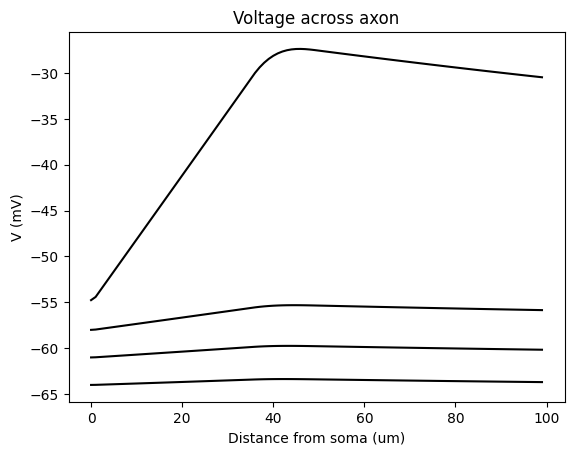

In [5]:
#4B 
from brian2 import *

EL = -75*mV  
S = 7.85e-9 * meter**2  
Cm = 0.75 * uF / cm**2  
gL = 1. / (30000 * ohm * cm**2) 
Ri = 150 * ohm * cm 

ENa = 60*mV 
ka = 6*mV  
va = -40*mV  
gNa_0 = gL * 2 * S  
taum = 0.1*ms  

defaultclock.dt = 0.025*ms

morpho = Soma(50*um)  
morpho.axon = Cylinder(diameter=1*um, length=300*um, n=300)  

Na_start = (25 + 10)*um
Na_end = (40 + 10)*um
linear_distribution = True 

duration = 500*ms

eqs='''
Im = gL*(EL - v) + gclamp*(vc - v) + gNa*m*(ENa - v) : amp/meter**2
dm/dt = (minf - m) / taum: 1  # simplified Na channel
minf = 1 / (1 + exp((va - v) / ka)) : 1
gclamp : siemens/meter**2
gNa : siemens/meter**2
vc = EL + 50*mV * t / duration : volt (shared)  # Voltage clamp with a ramping voltage command
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=Cm, Ri=Ri,
                       method="exponential_euler")
compartments = morpho.axon[Na_start:Na_end]
neuron.v = EL
neuron.gclamp[0] = gL*500

if linear_distribution:
    profile = linspace(1, 0, len(compartments))
else:
    profile = ones(len(compartments))
profile = profile / sum(profile)  # normalization

neuron.gNa[compartments] = gNa_0 * profile / neuron.area[compartments]

mon = StateMonitor(neuron, 'v', record=True)

run(duration, report='text')

dt_per_volt = len(mon.t) / (50*mV)  
for v in [-64*mV, -61*mV, -58*mV, -55*mV]:
    plot(mon.v[:100, int(dt_per_volt * (v - EL))]/mV, 'k')
xlabel('Distance from soma (um)')
ylabel('V (mV)')
title('Voltage across axon')


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s


Text(0.5, 1.0, 'Voltage across axon')

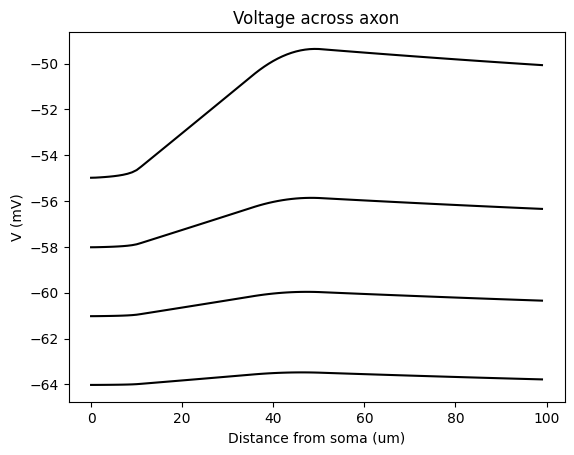

In [6]:
#4E

from brian2 import *

EL = -75*mV  
S = 7.85e-9 * meter**2  
Cm = 0.75 * uF / cm**2  
gL = 1. / (30000 * ohm * cm**2) 
Ri = 150 * ohm * cm 

ENa = 60*mV 
ka = 6*mV  
va = -40*mV  
gNa_0 = gL * 2 * S  
taum = 0.1*ms  

defaultclock.dt = 0.025*ms

morpho = Soma(50*um) 
diameters = hstack([linspace(4, 1, 11), ones(290)])*um
morpho.axon = Section(diameter=diameters, length=ones(300)*um, n=300)


Na_start = (25 + 10)*um
Na_end = (40 + 10)*um
linear_distribution = False 

duration = 500*ms

eqs='''
Im = gL*(EL - v) + gclamp*(vc - v) + gNa*m*(ENa - v) : amp/meter**2
dm/dt = (minf - m) / taum: 1  # simplified Na channel
minf = 1 / (1 + exp((va - v) / ka)) : 1
gclamp : siemens/meter**2
gNa : siemens/meter**2
vc = EL + 50*mV * t / duration : volt (shared)  # Voltage clamp with a ramping voltage command
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=Cm, Ri=Ri,
                       method="exponential_euler")
compartments = morpho.axon[Na_start:Na_end]
neuron.v = EL
neuron.gclamp[0] = gL*500

if linear_distribution:
    profile = linspace(1, 0, len(compartments))
else:
    profile = ones(len(compartments))
profile = profile / sum(profile)  # normalization

neuron.gNa[compartments] = gNa_0 * profile / neuron.area[compartments]

mon = StateMonitor(neuron, 'v', record=True)

run(duration, report='text')

dt_per_volt = len(mon.t) / (50*mV) 
for v in [-64*mV, -61*mV, -58*mV, -55*mV]:
    plot(mon.v[:100, int(dt_per_volt * (v - EL))]/mV, 'k')
xlabel('Distance from soma (um)')
ylabel('V (mV)')
title('Voltage across axon')


Starting simulation at t=0. s for a duration of 0.5 s
0.5 s (100%) simulated in 5s


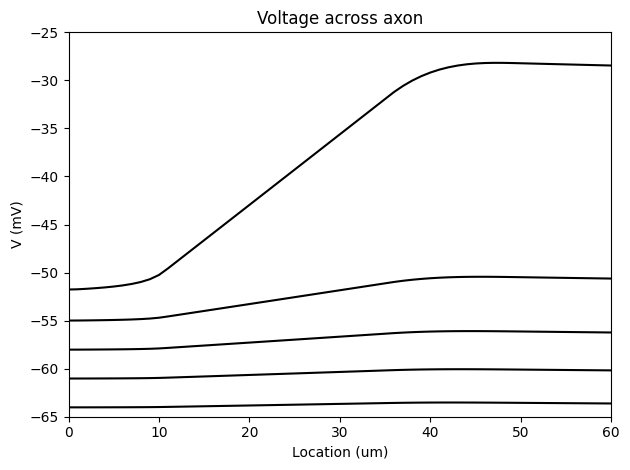

In [7]:
#4F

from brian2 import *

EL = -75*mV  
S = 7.85e-9 * meter**2  
Cm = 0.75 * uF / cm**2  
gL = 1. / (30000 * ohm * cm**2) 
Ri = 150 * ohm * cm 

ENa = 60*mV 
ka = 6*mV  
va = -40*mV  
gNa_0 = gL * 2 * S  
taum = 0.1*ms  

defaultclock.dt = 0.025*ms

morpho = Soma(50*um) # chosen for a target Rm
diameters = hstack([linspace(4, 1, 11), ones(290)])*um
morpho.axon = Section(diameter=diameters, length=ones(300)*um, n=300)


Na_start = (25 + 10)*um
Na_end = (40 + 10)*um
linear_distribution = True 

duration = 500*ms


eqs='''
Im = gL*(EL - v) + gclamp*(vc - v) + gNa*m*(ENa - v) : amp/meter**2
dm/dt = (minf - m) / taum: 1  # simplified Na channel
minf = 1 / (1 + exp((va - v) / ka)) : 1
gclamp : siemens/meter**2
gNa : siemens/meter**2
vc = EL + 50*mV * t / duration : volt (shared)  # Voltage clamp with a ramping voltage command
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=Cm, Ri=Ri,
                       method="exponential_euler")
compartments = morpho.axon[Na_start:Na_end]
neuron.v = EL
neuron.gclamp[0] = gL*500

if linear_distribution:
    profile = linspace(1, 0, len(compartments))
else:
    profile = ones(len(compartments))
profile = profile / sum(profile)  # normalization

neuron.gNa[compartments] = gNa_0 * profile / neuron.area[compartments]

mon = StateMonitor(neuron, 'v', record=True)

run(duration, report='text')

dt_per_volt = len(mon.t) / (50*mV)
for v in [-64*mV, -61*mV, -58*mV, -55*mV, -52*mV]:
    plot(mon.v[:100, int(dt_per_volt * (v - EL))]/mV, 'k')
xlim(0, 50+10)
ylim(-65, -25)
ylabel('V (mV)')
xlabel('Location (um)')
title('Voltage across axon')
tight_layout()
show()

A circular data cloud has no preferred direction. This means that the weight vector is initialized randomly. The final weight vector will have a fixed norm but will point in the same direction as it was initialized, since the data has no preference.
A smaller eta would slow learning, potentially making the outcome more stable but slower to converge. Learning rate affects how much each data point influences the weights. 

![image.png](attachment:image.png)

# mss ISI gebruiken? 

# Figure 5

WARNING    'i' is an internal variable of group 'synapses', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO       No numerical integration method specified for group 'spatialneuron_2', using method 'heun' (took 0.06s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]
WARNING    'v' is an internal variable of group 'spatialneuron_2', but also exists in the run namespace with the value -52. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'spatialneuron_2', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'synapses', but also exists in the run namespace with the value -52. * mvolt. The internal variable will be used. [

Starting simulation at t=0. s for a duration of 1. s
0.69235 s (69%) simulated in 10s, estimated 4s remaining.
1. s (100%) simulated in 13s


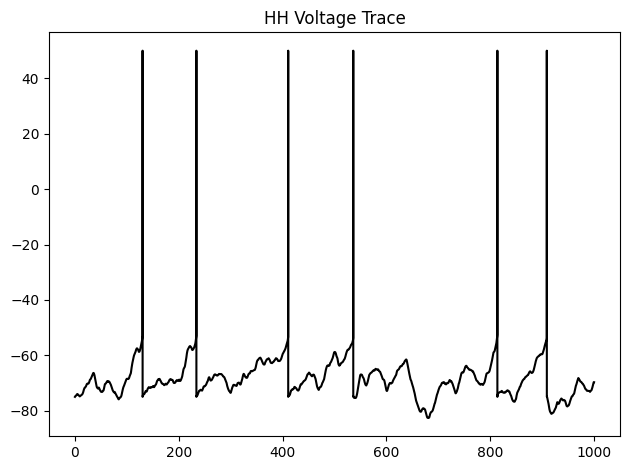

In [8]:
from brian2 import *

start_scope()

duration = 1000 * ms
dt = 0.025 * ms
defaultclock.dt = dt

EL = -75*mV  # resting membrane potential
S = 7.85e-9 * meter**2  # membrane surface area (sphere of 50 μm diameter)
Cm = 0.75 * uF / cm**2  # specific membrane capacitance
gL = 1. / (30000 * ohm * cm**2)  # leak conductance per unit area
Ri = 150 * ohm * cm  # axial resistance

# Na+ channel parameters
ENa = 60*mV  # Na+ reversal potential
ka = 6*mV  # activation slope
va = -40*mV  # activation half-voltage
gNa_0 = gL * 2 * S  # sodium conductance
taum = 0.1*ms  # Na+ activation time constant

morpho = Soma(50*um)  
morpho.axon = Cylinder(diameter=1*um, length=300*um, n=300)

# input
taux = 5*ms
sigmax = 12*mV
xx0 = 7*mV

compartment = 40

eqs = '''
Im = gL * (EL - v) + gNa * m * (ENa - v) + gLx * (xx0 + xx) : amp/meter**2
dm/dt = (minf - m) / taum : 1  # simplified Na channel
minf = 1 / (1 + exp((va - v) / ka)) : 1
gNa : siemens/meter**2
gLx : siemens/meter**2
dxx/dt = -xx / taux + sigmax * (2 / taux)**.5 *xi : volt
'''

neuron = SpatialNeuron(morphology=morpho, model=eqs, Cm=Cm, Ri=Ri,
                       threshold='m>0.5', threshold_location=compartment,
                       refractory=5*ms)

neuron.v = EL
neuron.gLx[0] = gL
neuron.gNa[compartment] = gNa_0 / neuron.area[compartment]

# reset the entire neuron when there is a spike
reset = Synapses(neuron, neuron, on_pre='v = EL')
reset.connect('i == compartment')  


S = SpikeMonitor(neuron)
M = StateMonitor(neuron, 'v', record=0)
run(duration, report='text')

# spikes
v = M[0].v
for t in S.t:
    v[int(t / defaultclock.dt)] = 50*mV

plot(M.t/ms, v/mV, 'k')
plt.title("HH Voltage Trace")
tight_layout()
show()

WARNING    't' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 0.909 * second. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 3s


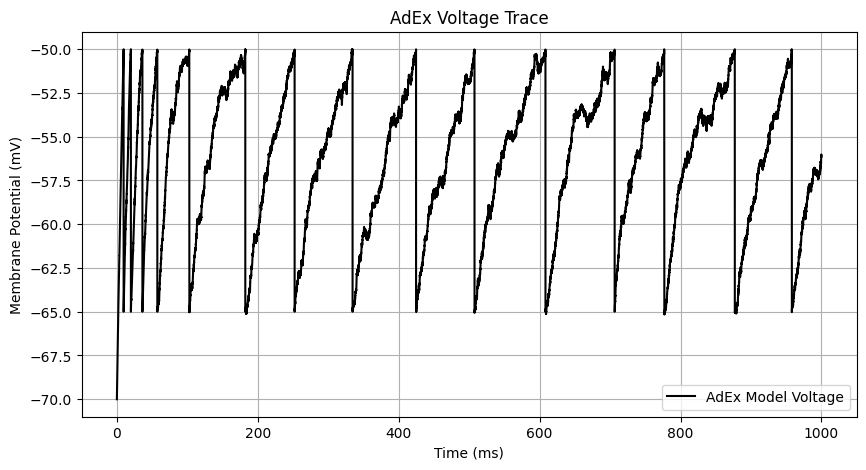

Mean Voltage (AdEx Model): -56.22 mV
Voltage Standard Deviation (AdEx Model): 4.09 mV
Firing Rate (AdEx Model): 15.00 Hz
Total Spikes (AdEx Model): 15


In [9]:
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory

b2.defaultclock.dt = 0.025 * b2.ms  

duration = 1000 * b2.ms 

t_start = 50 * b2.ms
t_end = 900 * b2.ms
I_mean = 0.5 * b2.nA  
I_std = 0.3 * b2.nA

time_array = np.arange(0, duration / b2.ms, b2.defaultclock.dt / b2.ms) * b2.ms
current_fluct = I_mean + I_std * np.random.randn(len(time_array)) 
I_injected = b2.TimedArray(current_fluct, dt=b2.defaultclock.dt)

C = 200 * b2.pF
gL = 10 * b2.nS  
EL = -70 * b2.mV 
V_threshold = -50 * b2.mV 
V_reset = -65 * b2.mV  


tau_w = 300 * b2.ms 
a = 4 * b2.nS  
b = 0.080 * b2.nA 

eqs_adex = '''
dV/dt = (gL * (EL - V) + I_injected(t) - w) / C : volt
dw/dt = (a * (V - EL) - w) / tau_w : amp
'''

adex_neuron = b2.NeuronGroup(1, eqs_adex, threshold='V > V_threshold',
                             reset='V = V_reset; w += b', method='euler')

adex_neuron.V = EL
adex_neuron.w = 0 * b2.nA  

state_mon_adex = b2.StateMonitor(adex_neuron, ['V'], record=True)
spike_mon_adex = b2.SpikeMonitor(adex_neuron)

net = b2.Network(adex_neuron, state_mon_adex, spike_mon_adex)
net.run(duration, report='text')


plt.figure(figsize=(10, 5))
plt.plot(state_mon_adex.t / b2.ms, state_mon_adex.V[0] / b2.mV, 'k', label="AdEx Model Voltage")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.title("AdEx Voltage Trace")
plt.legend()
plt.grid()
plt.show()

mean_v = np.mean(state_mon_adex.V[0] / b2.mV)
std_v = np.std(state_mon_adex.V[0] / b2.mV)

print(f"Mean Voltage (AdEx Model): {mean_v:.2f} mV")
print(f"Voltage Standard Deviation (AdEx Model): {std_v:.2f} mV")


firing_rate_adex = len(spike_mon_adex.t) / (duration / b2.second)

print(f"Firing Rate (AdEx Model): {firing_rate_adex:.2f} Hz")

print(f"Total Spikes (AdEx Model): {len(spike_mon_adex.t)}")


--> zelfde